In [1]:
from PreProcess.navigate import get_data, open_dat_file, crop_data, channel_outlier_marker, raw_from_layout, find_dat, trial_ieeg
from PreProcess.utils.plotting import figure_compare
import os.path as op
import mne

# %% Set up logging
mne.set_log_file("output.log",
                "%(levelname)s: %(message)s - %(asctime)s",
                overwrite=True)
mne.set_log_level("INFO")

In [2]:
# %% Load the data
TASK = "SentenceRep"
sub_num = 29
subj = "D" + str(sub_num).zfill(4)
HOME = op.expanduser("~")
LAB_root = op.join(HOME, "Box", "CoganLab")
layout = get_data("SentenceRep", root=LAB_root)
raw = raw_from_layout(layout, subject=subj, extension=".edf", desc=None, preload=False)
D_dat_raw, D_dat_filt = find_dat(op.join(LAB_root, "D_Data", TASK, "D" + str(sub_num)))
raw_dat = open_dat_file(D_dat_raw, raw.copy().ch_names)
dat = open_dat_file(D_dat_filt, raw.copy().ch_names)

C:\Users\Jakda\anaconda3\envs\preprocess\lib\site-packages\bids\layout\validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: participants.tsv file not found for C:\Users\Jakda\Box\CoganLab\BIDS-1.0_SentenceRep\BIDS\sub-D0029\ieeg\sub-D0029_task-SentenceRep_acq-01_run-01_ieeg.edf
  new_raw = read_raw_bids(bids_path=BIDS_path)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: participants.tsv file not found for C:\Users\Jakda\Box\CoganLab\BIDS-1.0_SentenceRep\BIDS\sub-D0029\ieeg\sub-D0029_task-SentenceRep_acq-01_run-02_ieeg.edf
  new_raw = read_raw_bids(bids_path=BIDS_path)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: participants.tsv file not found for C:\Users\Jakda\Box

In [3]:
# %% load filtered data
filt = raw_from_layout(layout.derivatives['clean'], subject=subj, extension='.edf', desc='clean', preload=True)

C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: The number of channels in the channels.tsv sidecar file (141) does not match the number of channels in the raw data file (140). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: participants.tsv file not found for C:\Users\Jakda\Box\CoganLab\BIDS-1.0_SentenceRep\BIDS\derivatives\clean\sub-D0029\ieeg\sub-D0029_task-SentenceRep_acq-01_run-01_desc-clean_ieeg.edf
  new_raw = read_raw_bids(bids_path=BIDS_path)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\navigate.py:116: RuntimeWarning: Omitted 166 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)


In [4]:
import matplotlib
%matplotlib inline
data = [raw, filt, raw_dat, dat]
figure_compare(data, ["BIDS Un", "BIDS ", "Un",""], avg=True, verbose=10, proj=True, fmax=250)
figure_compare(data, ["BIDS Un", "BIDS ", "Un",""], avg=False, verbose=10, proj=True, fmax=250)
del D_dat_raw, D_dat_filt, raw

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.8min finished
C:\Users\Jakda\anaconda3\envs\preprocess\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Jakda\git\IEEG_Pipelines\PreProcess\utils\plotting.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   20.2s remaining:   20.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   27.7s finished
C:\Users\Jakda\anaconda3\envs\preprocess\lib\site-packages\mne\viz\utils.py:1

In [5]:
# Crop raw data to minimize processing time
# new = crop_data(filt)
new = filt.copy()
# Mark channel outliers as bad
channel_outlier_marker(new, 5)

# Exclude bad channels
good = new.copy().drop_channels(new.info['bads'])
good.load_data()

# CAR
good.set_eeg_reference(ref_channels="average", ch_type='seeg')

# Remove intermediates from mem
del new

In [6]:
# fix SentenceRep events
from task.SentenceRep.events import fix_annotations
fix_annotations(good)

[]

In [7]:
# %% High Gamma Filter
HG_good = good.copy().filter(70, 150, n_jobs=-1).apply_hilbert(envelope=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.0min finished


In [8]:
from PreProcess.timefreq.fastmath import rescale
from PreProcess.timefreq.utils import crop_pad
resp = trial_ieeg(HG_good, "Word/Response", (-1.5, 1.5))
base = trial_ieeg(HG_good, "Start", (-1, 0.5))
resp.load_data(), base.load_data()
rescale(resp, base)
crop_pad(resp, "500ms")

Number of events,60
Events,18: 60
Time range,-1.000 – 1.000 sec
Baseline,off


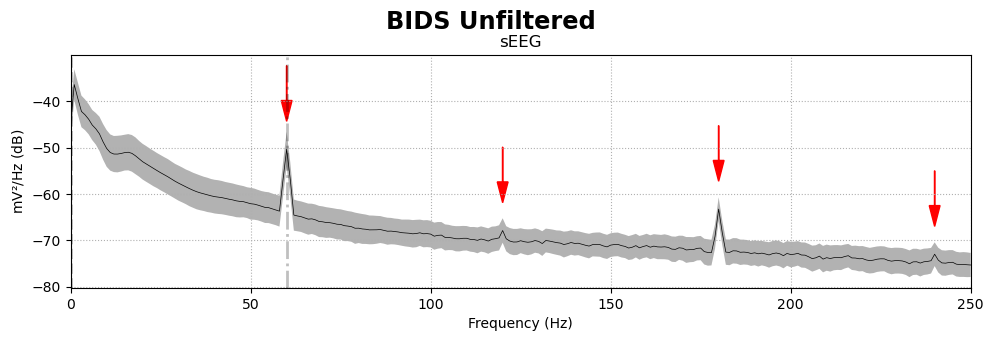

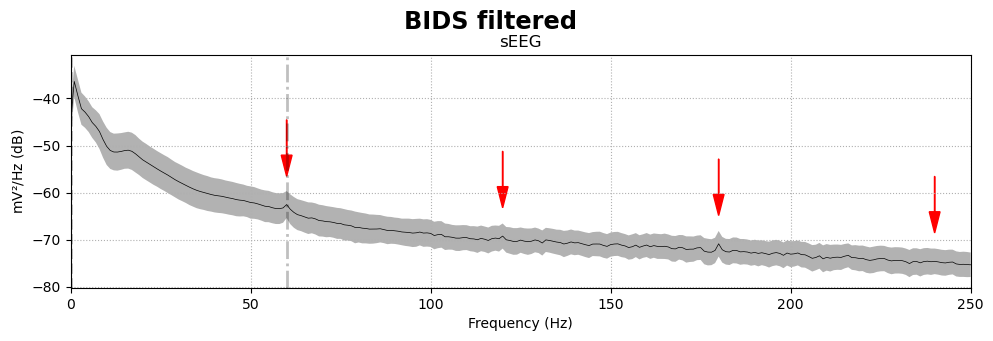

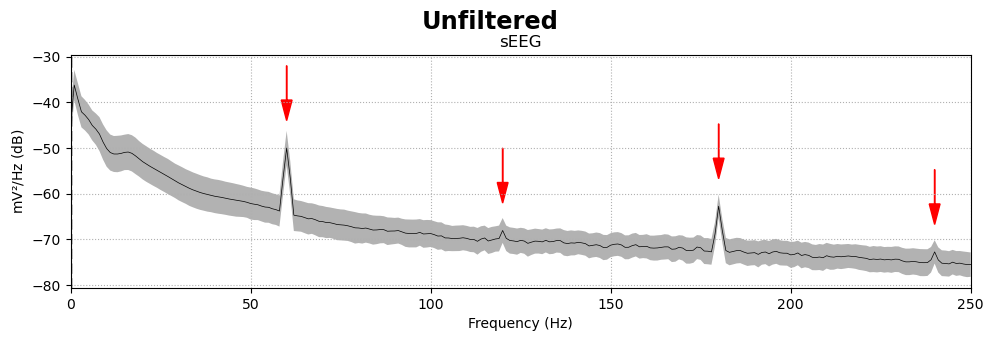

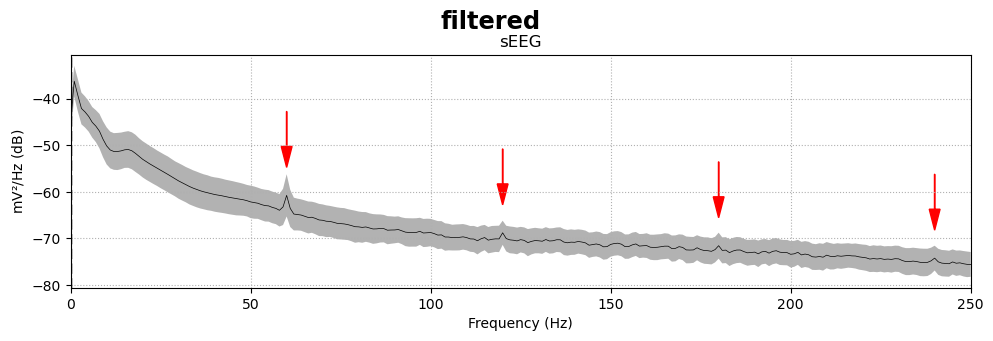

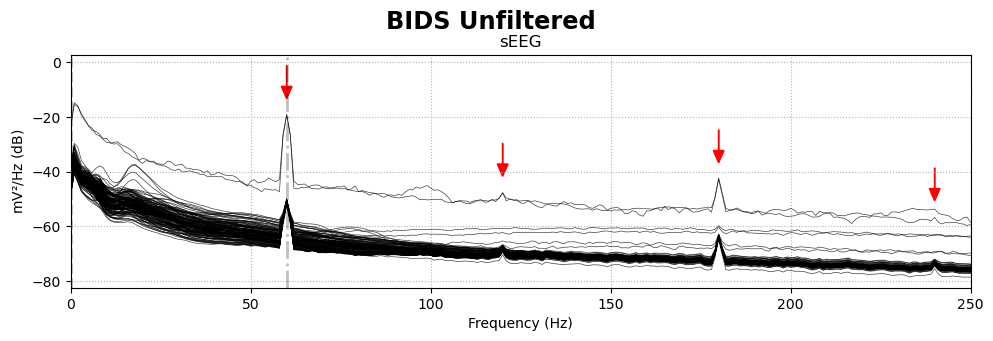

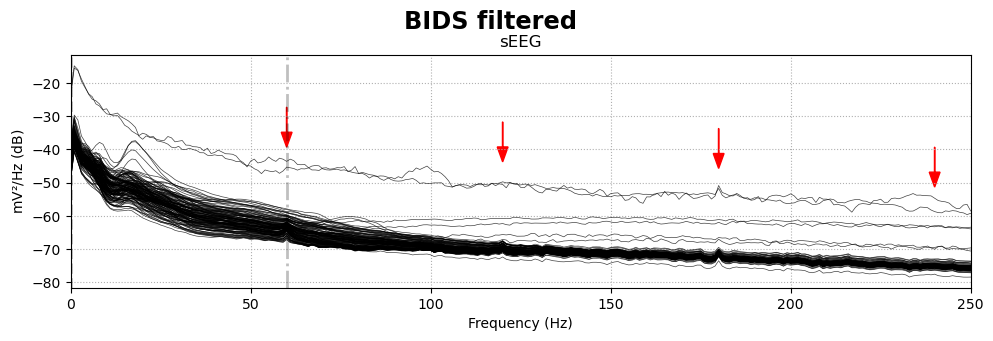

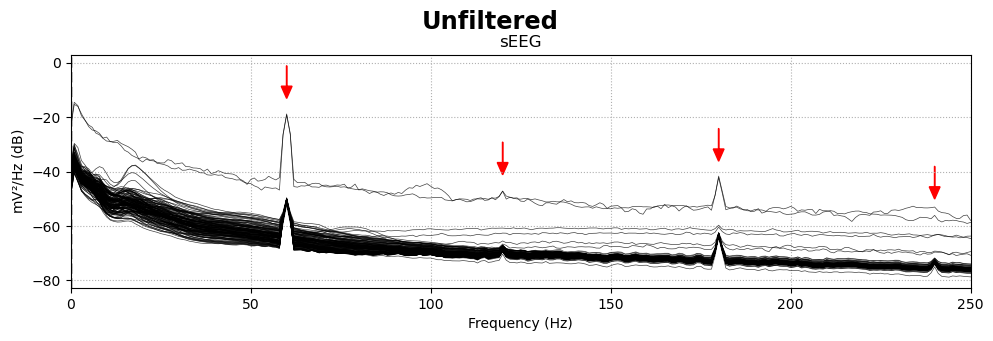

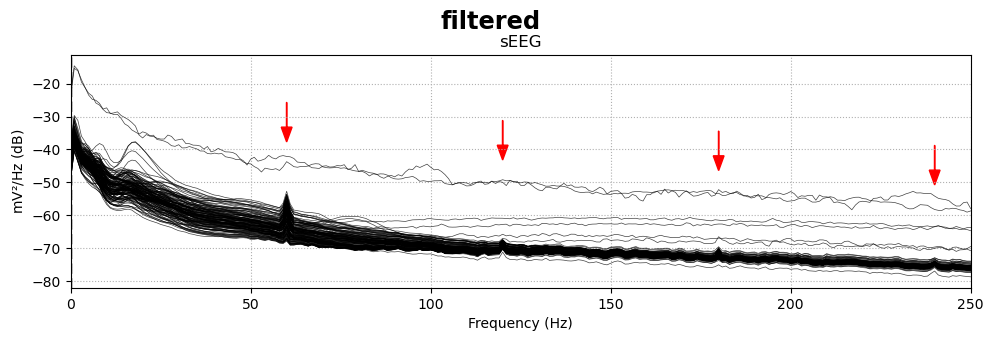

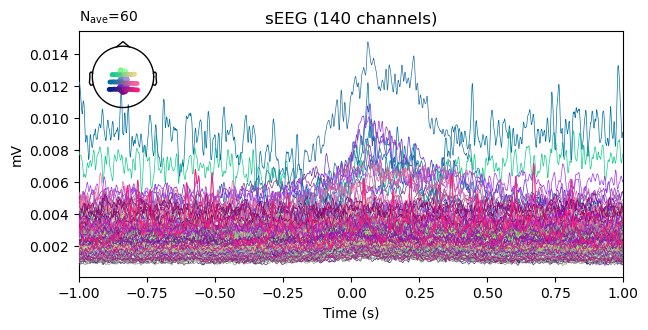

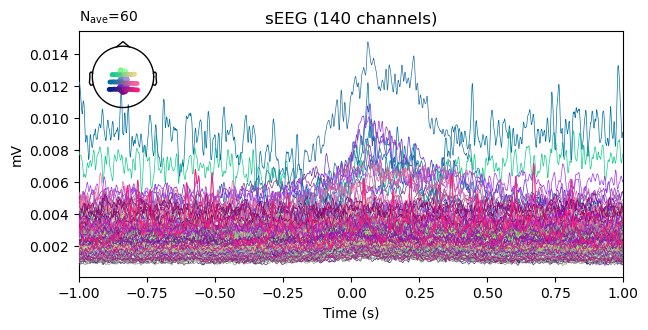

In [9]:
resp_evoke = resp.average()
resp_evoke.plot()